# Mario Stuff
(Code ideas taken from Nicholas Renotte's "Build an Mario AI Model with Python | Gaming Reinforcement Learning")

In [8]:
!pip install gym_super_mario_bros==7.3.0 nes_py

In [2]:
# Import the game
import gym_super_mario_bros

# Import joypad wrapper
from nes_py.wrappers import JoypadSpace

# Import the simplified controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [161]:
# Setup
env = gym_super_mario_bros.make('SuperMarioBros-v0')

# Simplify the controls from 256 different possible 
# movement combinations to just 7!
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [ ]:
# 240px, 256px, 3 color channels
env.observation_space.shape

In [ ]:
# Test code to show the format of how to run the game

# flag: Restart?
done = True

# each 'step' represents 1 frame
for step in range(1000):
    if done:
        env.reset() # Start the game
    # env.action_space.sample() chooses a random action
    state, reward, done, info, = env.step(env.action_space.sample())
    # Show the game on screen
    env.render()
# Close the game and remove the environment
env.close()

## Environment Preprocessing

In [4]:
# Install pytorch (for windows & Python using CUDA; 
#     go to pytorch.org to grab the correct command for your system)
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


In [11]:
# Install Stable Baselines3 which gives us a baseline RL model for training
!pip install stable-baselines3[extra]

In [3]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
# GrayScaleObservation allows us to run the game with just one image channel
#     instead of all three colors which should allow us to have faster learning
from gym.wrappers import GrayScaleObservation

# Import Vectorization Wrappers
# FrameStack allows us to capture some frames while playing the game
#     this allows our ai to gather information about the actions of other entities
#     that it wouldn't know from just one frame alone
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

# Import Matplotlib
from matplotlib import pyplot as plt

In [49]:
# Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')

# Simplify the controls
env = JoypadSpace(env, SIMPLE_MOVEMENT)

# Grayscale
env = GrayScaleObservation(env, keep_dim=True)

In [50]:
state = env.reset()

In [51]:
state.shape # Only 1 channel

(240, 256, 1)

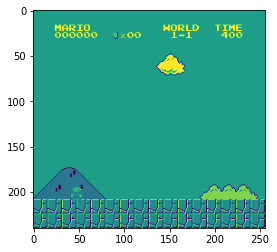

In [52]:
plt.imshow(state)

In [53]:
# Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])

In [54]:
state = env.reset()

In [55]:
state.shape # Frame is now in an array

(1, 240, 256, 1)

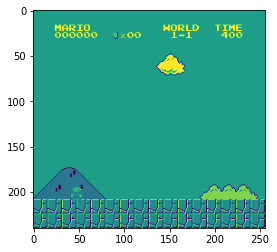

In [56]:
plt.imshow(state[0])

In [57]:
# Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [58]:
state = env.reset()

In [59]:
state.shape # AI can now see the last 4 frames

(1, 240, 256, 4)

In [70]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [88]:
state, reward, done, info = env.step([5])

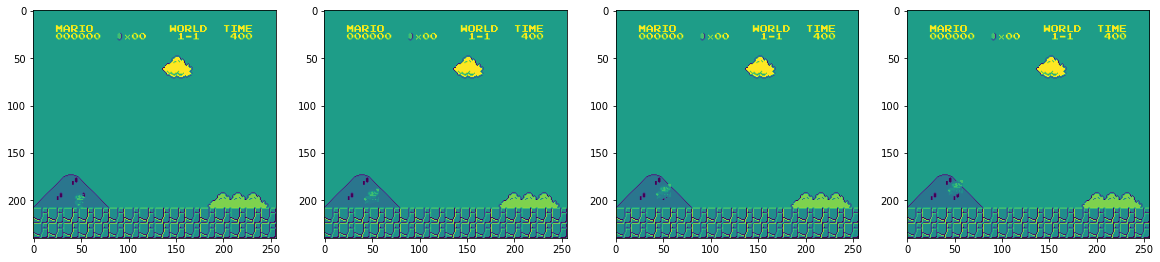

In [89]:
plt.figure(figsize=(20,16))
for frame in range(state.shape[3]):
    plt.subplot(1,4,frame+1)
    plt.imshow(state[0][:,:,frame])
plt.show()

## Train the Reinforcement Learning Model
We are using a PPO (Proximal Policy Optimization) alorithm for reinforcement learning.
This was developed by OpenAI, the team that made the gym framework.

In [27]:
# Import os for file path management
#     this helps to save our models and create back-ups while training
import os

# Import PPO for algorithms
from stable_baselines3 import PPO

# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [91]:
# This class was taken from Nicholas Renotte for backing-up a model during training
#     (It is optional and is not needed to run the model)
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
                                                                             
        return True

In [96]:
# Setup auto-save directory on personal machine
CHECKPOINT_DIR = '../../MarioAI/train/'
LOG_DIR = './logs/' # Use: "tensorboard --logdir=."
                            #  when inside the new folder inside
                            #  of the logs directory to view progress.

In [104]:
# Setup model auto-saving (optional)
callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

In [100]:
# This is the beginning of our AI model
#     We're using a convolutional neural network policy which is great for looking at images
#     We could also use CnnLstmPolicy, but that was for PPO 2, which isn't as stable as PPO 3
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001,
            n_steps=512)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [101]:
# Train the AI model, start learning!
#     timesteps represents how many frames our AI is going to see
#     Again, callback is optional
model.learn(total_timesteps=1000000, callback=callback)

Logging to ./MarioAI/logs/PPO_1


C:\Users\joshu\anaconda3\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 110 |
|    iterations      | 1   |
|    time_elapsed    | 4   |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 2            |
|    time_elapsed         | 10           |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 4.581525e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.95        |
|    explained_variance   | -0.00268     |
|    learning_rate        | 1e-06        |
|    loss                 | 80.9         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.000151    |
|    value_loss           | 283          |
------------------------------------------
-----------------------

In [106]:
model.save('../../MarioAI/models/model_1')

## Testing

In [44]:
# Load the model you want to test
model = PPO.load('../../MarioAI/models/model_1')

In [45]:
state = env.reset()

In [46]:
# Start the game
done = True

# Loop through the game
for _ in range(10000):
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

In [47]:
env.close() # gets rid of the env

ValueError: env has already been closed.